# Higher Criticsim for Large Language Model Trending with Massive Text Corpus

In [1]:
# Data Preprocessing
import os
import re
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Higher Criticism libraries
from multitest import MultiTest
from twosample import bin_allocation_test

## Load Data and Preprocessing

1. Tokenization: Split texts into words, preserving by phenated coumpounds
2. Build frequency tables: for each decade, construct word-frequency distributinos, excluding hapax legomena to reduce noise

## Data Preprocessing

In [2]:
# Extract text genre, year, and doc_id
def extract_metadata(filename):
    """Extract genre, year, and doc_id from filename"""
    parts = filename.split('_')
    if len(parts) >= 3:
        year = parts[1]
        doc_id = '_'.join(parts[2:]).split('.')[0]  # Remove file extension
        return year, doc_id
    return None, None

In [3]:
def preprocess_text(text):
    """Text preprocessing that preserves contractions like I'm, don't, etc."""
    # Make lowercase
    text = text.lower()

    # Remove numbers (words containing digits)
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Remove punctuation BUT keep apostrophes in contractions
    # This regex removes punctuation except apostrophes that are between word characters
    text = re.sub(r"[^\w\s']|'(?!\w)|(?<!\w)'", '', text)

    # Alternative approach: specifically preserve common contractions
    # text = re.sub(r"[^\w\s']+", '', text)  # Keep only word chars, spaces, apostrophes

    # Remove extra whitespace and tokenize
    words = text.split()

    # Filter out empty strings and standalone apostrophes
    words = [word for word in words if word.strip() and word != "'"]

    return words

In [4]:
def process_files(directory):
    """Process all files in directory and return structured data"""
    data = []

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            year, doc_id = extract_metadata(filename)
            if year is None:
                continue

            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                content = f.read()
                words = preprocess_text(content)
                word_counts = Counter(words)

                data.append({
                    'year': year,
                    'doc_id': doc_id,
                    'word_counts': word_counts,
                    'total_words': len(words)
                })

    return data

In [5]:
# Test
directory = 'test_data'
test_data = process_files(directory)

In [6]:
# get full data
directory = 'data'
full_data = process_files(directory)

### Create Frequency Table

In [7]:
# create word frequency tables for year or decade
def create_frequency_tables(data, groupby='year'):
    """
    Create word frequency tables by year or decade

    Parameters:
    -----------
    data : list of dict
        List of documents with 'year', 'word_counts', and 'total_words' keys
    groupby : str, default 'year'
        Either 'year' or 'decade' to specify grouping method

    Returns:
    --------
    freq_table : pd.DataFrame
        Frequency table with words as rows and years/decades as columns
    period_totals : dict
        Total word counts for each year/decade
    """

    def get_decade(year):
        year = int(year)
        """Convert year to decade (e.g., 1985 -> 1980s)"""
        decade_start = (year // 10) * 10
        return f"{decade_start}s"

    # Initialize counters
    period_vocab = defaultdict(Counter)
    period_total_words = defaultdict(int)

    # Process each document
    for doc in data:
        year = doc['year']

        # Determine the grouping period
        if groupby == 'decade':
            period = get_decade(year)
        elif groupby == 'year':
            period = year
        else:
            raise ValueError("groupby must be either 'year' or 'decade'")

        # Update counters
        period_vocab[period].update(doc['word_counts'])
        period_total_words[period] += doc['total_words']

    # Get all periods and words
    all_periods = sorted(period_vocab.keys())
    all_words = set()

    for period in all_periods:
        all_words.update(period_vocab[period].keys())

    # Create frequency table (words x periods)
    freq_table = pd.DataFrame(index=list(all_words), columns=all_periods)

    # Fill the frequency table with normalized frequencies
    for word in all_words:
        for period in all_periods:
            if period_total_words[period] > 0:  # Avoid division by zero
                freq_table.loc[word, period] = period_vocab[period].get(word, 0) / period_total_words[period]
            else:
                freq_table.loc[word, period] = 0

    # Set index and column names
    freq_table.index.name = 'words'
    freq_table.columns.name = 'decades' if groupby == 'decade' else 'years'

    return freq_table, period_total_words

In [8]:
# Example usage

# For yearly frequency tables (original functionality)
freq_table_yearly, year_totals = create_frequency_tables(test_data, groupby='year')

# For decade frequency tables (new functionality)
freq_table_decades, decade_totals = create_frequency_tables(full_data, groupby='decade')
# print(freq_table_decades.head())

### Apply Higher Critisim on Frequency Table

In [9]:
def two_sample_hc_analysis(freq_table, year1, year2, year_totals, gamma=0.05):
    """
    Enhanced version that returns both statistics and the list of significant words
    """
    # Get valid words (those with frequency > 0 in at least one year)
    p1 = freq_table[year1].fillna(0)
    p2 = freq_table[year2].fillna(0)

    # Filter words that appear in at least one year
    valid_mask = (p1 > 0) | (p2 > 0)
    valid_words = freq_table.index[valid_mask]

    if len(valid_words) == 0:
        return {
            'year1': year1,
            'year2': year2,
            'HC_statistic': 0,
            'HC_threshold': 0,
            'significant_features': 0,
            'total_words': 0,
            'significant_words': []
        }

    # Get frequencies for valid words only
    p1_valid = p1[valid_mask]
    p2_valid = p2[valid_mask]

    # Get total word counts
    n1 = year_totals[year1]
    n2 = year_totals[year2]

    # Convert frequencies to counts
    counters1 = (p1_valid * n1).round().astype(int)
    counters2 = (p2_valid * n2).round().astype(int)

    # Ensure no negative counts
    counters1 = np.maximum(counters1, 0)
    counters2 = np.maximum(counters2, 0)

    # Calculate p-values for each word
    pvals = bin_allocation_test(counters1, counters2)

    pv = pvals[~np.isnan(pvals)]
    pv = pv[pv < gamma]

    # Apply Higher Criticism
    mt = MultiTest(pv)
    hc_val, t_star = mt.hc(gamma)

    # Find words with p-values below the HC threshold
    significant_mask = pvals < t_star
    significant_words = valid_words[significant_mask].tolist()

    return {
        'year1': year1,
        'year2': year2,
        'HC_statistic': hc_val,
        'HC_threshold': t_star,
        'significant_features': len(significant_words),
        'total_words': len(pvals),
        'significant_words': significant_words
    }

In [10]:
# Example usage:
result = two_sample_hc_analysis(freq_table_yearly, '1827', '1896', year_totals)
print(f"HC statistic: {result['HC_statistic']}")
print(len(result['significant_words']))

HC statistic: 7.541744273125771
52


In [11]:
significant_words = result['significant_words']
# print the significant words, do they really can represent the trend?
significant_words[:10]

['said',
 'mr',
 'have',
 'hafez',
 'god',
 'me',
 'bohemond',
 'alex',
 'was',
 'alexius']

In [12]:
result = two_sample_hc_analysis(freq_table_decades, '1810s', '1890s', decade_totals)
print(f"HC statistic: {result['HC_statistic']}")
print(len(result['significant_words']))

HC statistic: 7.256462635283324
49


In [13]:
# Compare all years
def compare_all_years(freq_table, year_totals):
# def compare_all_years(freq_table, year_totals, method='two_sample_hc'):
    """Compare all pairs of years"""
    years = sorted(freq_table.columns)
    results = []
    words_changes = {}
    for i in range(len(years)):
        for j in range(i+1, len(years)):
            year1 = years[i]
            year2 = years[j]
            words_changes[(year1, year2)] = []
            result = two_sample_hc_analysis(freq_table, year1, year2, year_totals)
            results.append(result)

    return pd.DataFrame(results)

In [14]:
# Run comparisons
two_sample_results = compare_all_years(freq_table_yearly, year_totals)
print("\nTwo Sample HC Results:")
print(two_sample_results)



Two Sample HC Results:
    year1 year2  HC_statistic  HC_threshold  significant_features  \
0    1817  1821      3.560242  5.140905e-31                    11   
1    1817  1827      4.113640  3.339765e-25                    15   
2    1817  1829      5.807608  3.258144e-16                    31   
3    1817  1830      3.562770  3.408006e-15                    11   
4    1817  1831      2.522289  4.941596e-07                     5   
..    ...   ...           ...           ...                   ...   
131  1865  1884      2.304181  1.283367e-07                     3   
132  1865  1896      2.299662  7.588354e-08                     3   
133  1867  1884      3.830648  2.192200e-04                    13   
134  1867  1896      4.086791  2.368468e-04                    12   
135  1884  1896      9.897830  1.750613e-14                    92   

     total_words                                  significant_words  
0           4533  [count, almeyda, car, my, carlos, of, i, pacom...  
1      

In [15]:
# Run comparisons
two_sample_results_decades = compare_all_years(freq_table_decades, decade_totals)
print("\nTwo Sample HC Results:")
print(two_sample_results_decades)


Two Sample HC Results:
     year1  year2  HC_statistic  HC_threshold  significant_features  \
0    1810s  1820s      5.622685  1.605616e-20                    29   
1    1810s  1830s      5.336614  3.215682e-28                    26   
2    1810s  1840s      5.988028  3.830204e-27                    33   
3    1810s  1850s      4.817132  4.732184e-32                    21   
4    1810s  1860s      4.817132  1.041525e-32                    21   
..     ...    ...           ...           ...                   ...   
185  1970s  1990s     12.097362  6.313090e-15                   138   
186  1970s  2000s     10.861391  1.135319e-11                   111   
187  1980s  1990s     11.287846  8.000571e-13                   120   
188  1980s  2000s     11.288217  1.539720e-13                   120   
189  1990s  2000s     11.471990  5.610878e-13                   124   

     total_words                                  significant_words  
0          10537  [yes, n't, and, sir, almeyda, gusma

In [16]:
## fit for both years or decades
def track_significant_words_across_time(freq_table, time_totals, gamma=0.05, time_points=None):
    """
    Tracks significant words across adjacent time points (years or decades) using Higher Criticism.

    Parameters:
    - freq_table: DataFrame with words as rows and time labels (years or decades) as columns.
    - time_totals: Dict mapping each time label to total word count.
    - gamma: Truncation parameter for HC.
    - time_points: Optional list defining the order of time comparisons (default: freq_table.columns).

    Returns:
    - sig_matrix: Binary DataFrame [|W| x |T|] indicating significance per time point.
    - hc_stats: Dict mapping (t1, t2) → HC score.
    """
    import pandas as pd
    from collections import defaultdict

    if time_points is None:
        time_points = list(freq_table.columns)

    vocabulary = freq_table.index
    sig_matrix = pd.DataFrame(0, index=vocabulary, columns=time_points)
    hc_stats = {}

    for i in range(len(time_points) - 1):
        t1, t2 = time_points[i], time_points[i + 1]

        p1 = freq_table[t1].fillna(0)
        p2 = freq_table[t2].fillna(0)

        valid_mask = (p1 > 0) | (p2 > 0)
        valid_words = freq_table.index[valid_mask]
        if len(valid_words) == 0:
            continue

        n1, n2 = time_totals[t1], time_totals[t2]
        c1 = (p1[valid_words] * n1).round().astype(int).clip(lower=0)
        c2 = (p2[valid_words] * n2).round().astype(int).clip(lower=0)

        pvals = bin_allocation_test(c1, c2)
        # sorted_pvals = sorted(pvals)
        pv = pvals[~np.isnan(pvals)]
        pv= pv[pv < gamma]

        mt = MultiTest(pv)
        hc_val, t_star = mt.hc(gamma=gamma)

        significant_mask = pvals < t_star
        significant_words = valid_words[significant_mask]

        sig_matrix.loc[significant_words, t2] = 1
        hc_stats[(t1, t2)] = hc_val

    return sig_matrix, hc_stats


In [17]:
year_sig_matrix, year_hc_stats = track_significant_words_across_time(freq_table_yearly, year_totals)

In [18]:
# For decade-level analysis
decade_sig_matrix, decade_hc_scores = track_significant_words_across_time(freq_table=freq_table_decades,
                                                            time_totals=decade_totals)


In [ ]:
decade_sig_matrix

In [ ]:
decade_hc_scores

In [19]:
# update to fit the decades as well
def detect_period_trend_words(sig_matrix, target_periods, min_diff=0.3, top_n=20, return_all_scores=False):
    """
    Identify words whose significance is concentrated in a specific period.

    Parameters:
    - sig_matrix: Binary DataFrame [|W| x |T|] indicating significance per time point (e.g., year or decade)
    - target_periods: List of time points (strings or integers) defining the target period
    - min_diff: Minimum difference in significance rate to consider a word period-specific
    - top_n: Number of top words to return
    - return_all_scores: If True, also return the full dictionary of contrast scores

    Returns:
    - significant_trend_words: List of (word, delta) tuples with delta ≥ min_diff, sorted by |delta|
    - [Optional] trend_scores: Dictionary of all word → delta scores
    """
    # Ensure consistent string matching if needed
    all_periods = list(sig_matrix.columns)
    target_periods = [str(p) for p in target_periods]
    other_periods = [p for p in all_periods if p not in target_periods]

    trend_scores = {}
    for word in sig_matrix.index:
        target_rate = sig_matrix.loc[word, target_periods].mean()
        reference_rate = sig_matrix.loc[word, other_periods].mean()
        delta = target_rate - reference_rate
        trend_scores[word] = delta

    # Sort by absolute contrast
    sorted_words = sorted(trend_scores.items(), key=lambda x: abs(x[1]), reverse=True)

    # Filter by significance threshold
    significant_trend_words = [(w, d) for w, d in sorted_words if abs(d) >= min_diff][:top_n]

    if return_all_scores:
        return significant_trend_words, trend_scores
    return significant_trend_words


In [20]:
year_trend_words = detect_period_trend_words(year_sig_matrix, ['1827','1896'])
print(year_trend_words)

[('was', 0.9333333333333333), ('his', 0.9333333333333333), ('at', 0.9333333333333333), ('will', 0.8666666666666667), ('my', 0.8), ('i', 0.6666666666666667), ('you', 0.6666666666666667), ('said', 0.5), ('most', 0.5), ('work', 0.5), ('mr', 0.5), ('representatives', 0.5), ('thomas', 0.5), ('into', 0.5), ('de', 0.5), ('machinery', 0.5), ('had', 0.5), ('father', 0.5), ('impeachment', 0.5), ('maudslay', 0.5)]


In [21]:
decade_trend_words = detect_period_trend_words(freq_table_decades, target_periods=['1920s', '1930s'], min_diff=0.1, top_n=100)
print(decade_trend_words)

[]


In [22]:
freq_table_decades[freq_table_decades>0]

decades,1810s,1820s,1830s,1840s,1850s,1860s,1870s,1880s,1890s,1900s,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s
words,,,,,,,,,,,,,,,,,,,,
garrisons,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN,0.000004,NaN,NaN,NaN,NaN,0.000003,NaN,NaN,NaN,NaN,0.000005,NaN
basing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000004,0.000034,NaN,NaN,NaN,0.000006,NaN,NaN,0.000003,0.00001,NaN,NaN
hence,NaN,0.000071,0.000118,0.000103,0.000084,0.000133,0.000072,0.000057,0.000064,0.000056,0.000036,0.00005,0.000031,0.000034,0.000008,0.000008,0.000015,0.000122,0.000023,0.000008
jethro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000004,NaN,NaN,NaN,NaN
anglicans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yeeeees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sanghwa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000004
buffa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualization

In [23]:
def plot_significant_heatmap(sig_matrix, top_n=50):
    # Get top words with highest total significance
    word_totals = sig_matrix.sum(axis=1)
    top_words = word_totals.sort_values(ascending=False).head(top_n).index
    sub_matrix = sig_matrix.loc[top_words]

    plt.figure(figsize=(12, 8))
    sns.heatmap(sub_matrix, cmap="YlGnBu", cbar=True, linewidths=0.5, linecolor='gray')
    plt.title("Top Significant Words Across Time")
    plt.xlabel("Time Period")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()


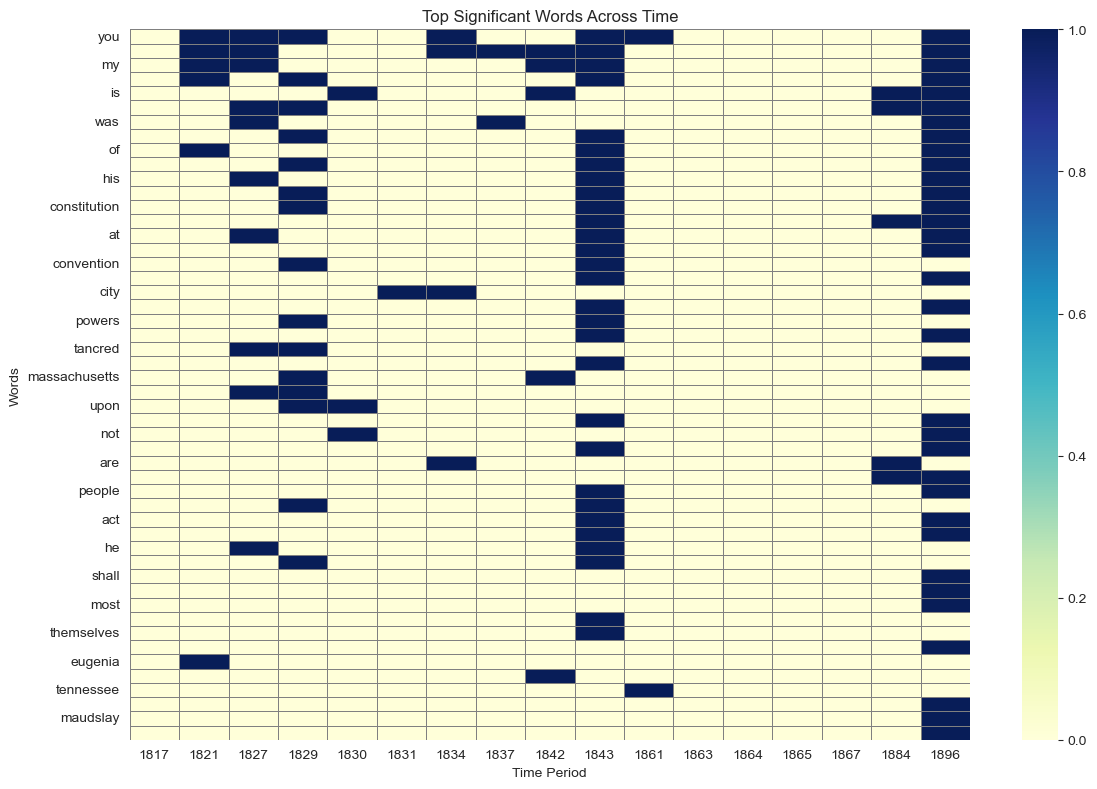

In [24]:
plot_significant_heatmap(year_sig_matrix)

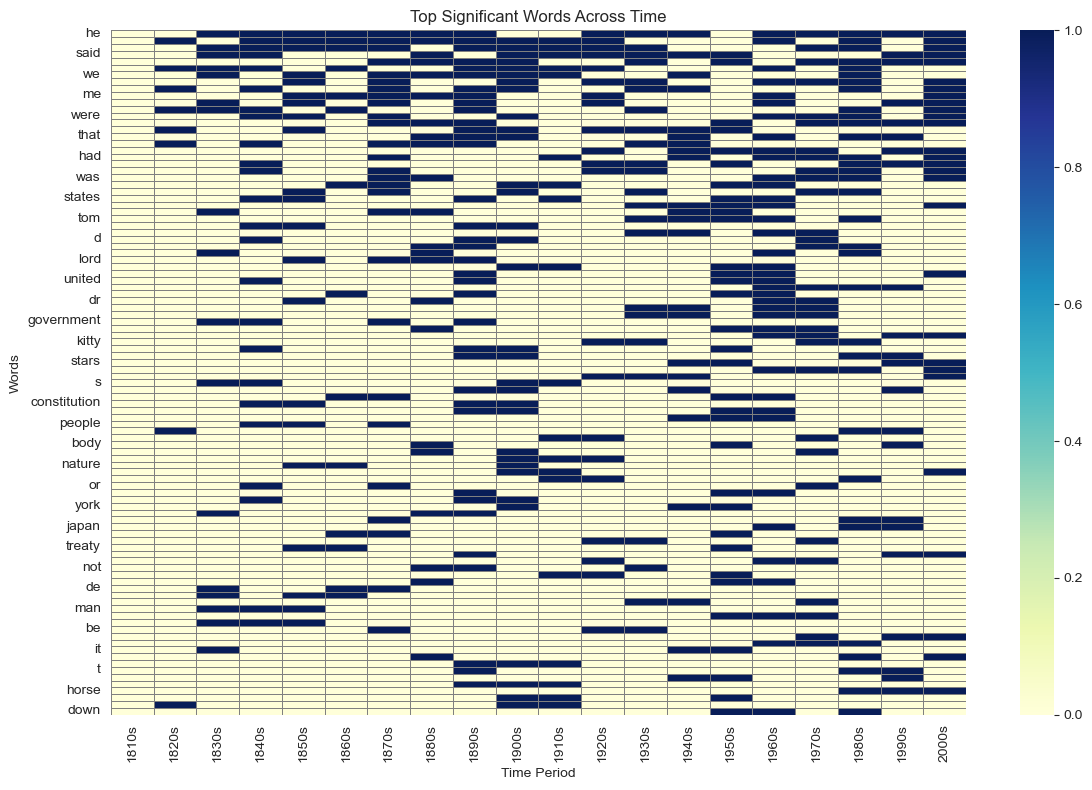

In [25]:
plot_significant_heatmap(decade_sig_matrix, top_n=100)

In [26]:
def plot_trend_words(trend_words, title='Period-Specific Trend Words'):

    words, scores = zip(*trend_words)
    df = pd.DataFrame({'word': words, 'score': scores})
    df = df.sort_values(by='score')

    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='word', data=df, palette='coolwarm')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(title)
    plt.xlabel("Contrast Score (Target Period vs. Others)")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()


C:\Users\14913\AppData\Local\Temp\ipykernel_71128\18064807.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='word', data=df, palette='coolwarm')


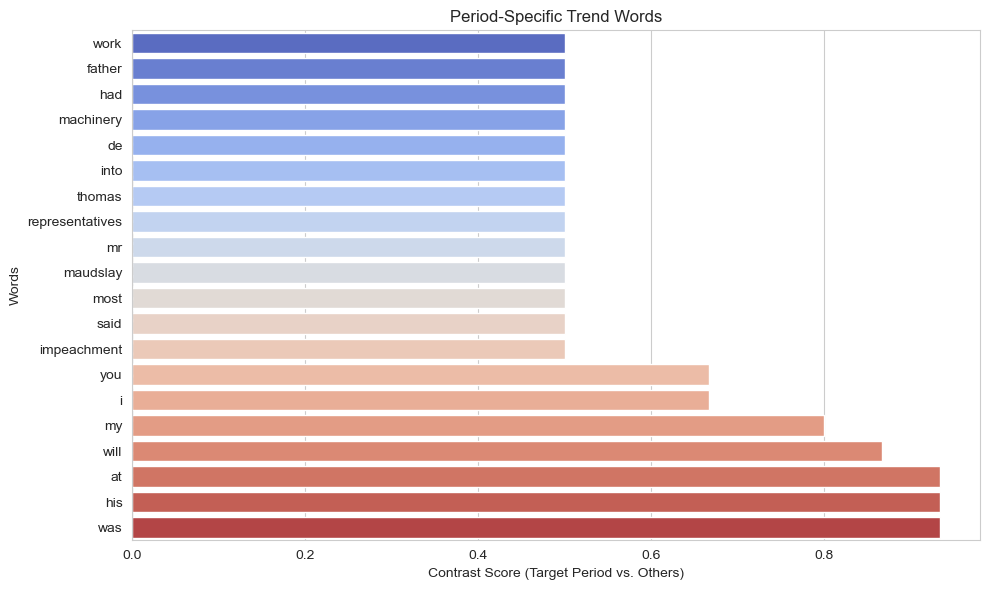

In [27]:
plot_trend_words(year_trend_words)

In [28]:
plot_trend_words(decade_trend_words)

ValueError: not enough values to unpack (expected 2, got 0)

In [32]:
decade_trend_words

[]

In [29]:
def plot_hc_scores(hc_stats):
    import pandas as pd

    pairs = list(hc_stats.keys())
    values = list(hc_stats.values())
    labels = [f"{p[0]}→{p[1]}" for p in pairs]

    df = pd.DataFrame({'Period Pair': labels, 'HC Score': values})

    plt.figure(figsize=(12, 5))
    sns.lineplot(x='Period Pair', y='HC Score', data=df, marker='o')
    plt.xticks(rotation=45, ha='right')
    plt.title("HC Score Between Adjacent Periods")
    plt.tight_layout()
    plt.show()


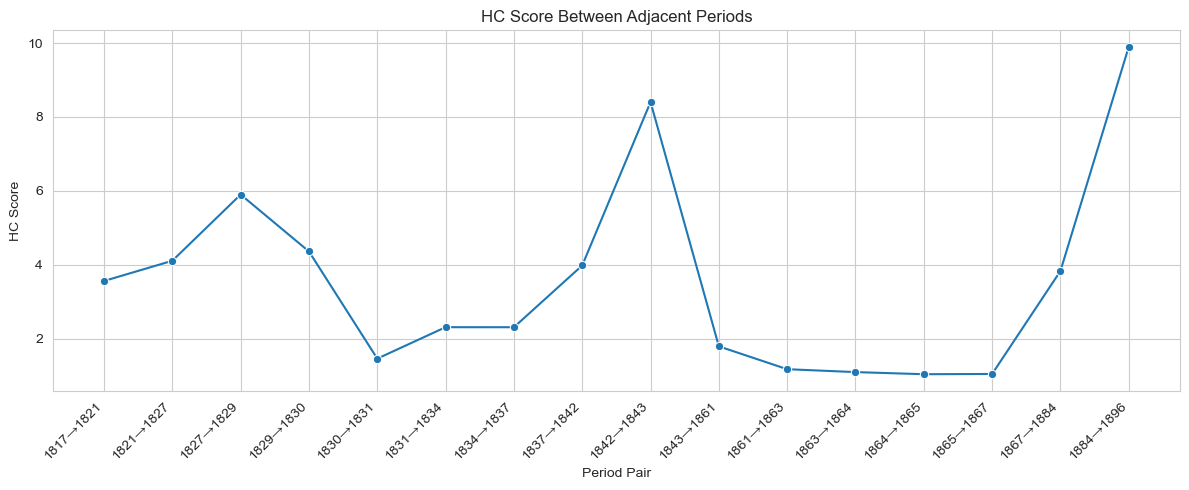

In [30]:
plot_hc_scores(year_hc_stats)

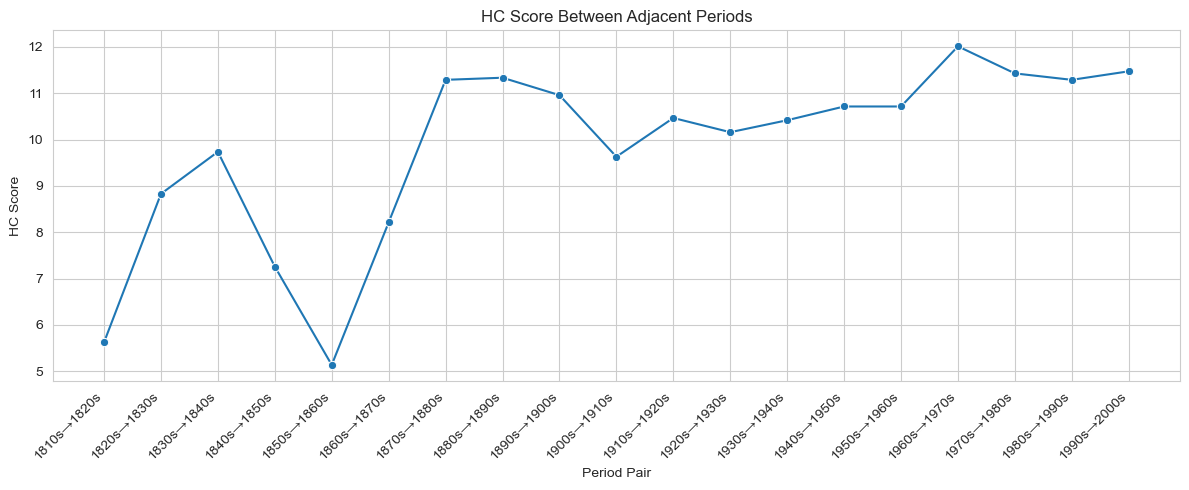

In [31]:
plot_hc_scores(decade_hc_scores)

Does the plot tell us that the connections between words usage are getting more similar???

### Report the words
Report the words that may indicate the language trend
(Print the words that are not the most frequent ones..?)